In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from config import (MAX_SEQUENCE_LENGTH, NUM_DISTINCT_WORDS,
                    EMBEDDING_OUTPUT_DIMS,DEFAULT_WORD_ID, INDEX_FROM)

## Load Data

In [2]:
# Model configuration
max_sequence_length = MAX_SEQUENCE_LENGTH #100  # 600 #100
num_distinct_words = NUM_DISTINCT_WORDS #10000
embedding_output_dims = EMBEDDING_OUTPUT_DIMS # 15

# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words,
                                                      start_char=DEFAULT_WORD_ID['<start>'],
                                                      oov_char=DEFAULT_WORD_ID['<unk>'],
                                                      index_from=INDEX_FROM)

print(x_train.shape)
print(x_test.shape)

# Pad all sequences
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>


(25000,)
(25000,)


In [3]:
# Obtain 3 texts
for i in np.random.randint(0, len(padded_inputs), 3):
  word_to_id = imdb.get_word_index()
  word_to_id = {k: (v+INDEX_FROM) for k, v in word_to_id.items()}
  word_to_id.update(DEFAULT_WORD_ID)

  id_to_word = {value: key for key, value in word_to_id.items()}
  print('=================================================')
  print(f'Sample = {i} | Length = {len(padded_inputs[i])}')
  print('=================================================')
  print(' '.join(id_to_word[id] for id in padded_inputs[i] ))

Sample = 12860 | Length = 700
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

## Create and compile model

In [4]:
# Define the Keras model
model = Sequential()
model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
model.add(Dropout(0.50))
model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.50))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.50))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
loss_function = 'binary_crossentropy'
optimizer = 'adam'
additional_metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

print("TensorFlow version:", tf.__version__)

# Print shapes and types of input data
print("padded_inputs shape:", padded_inputs.shape)
print("padded_inputs type:", type(padded_inputs))
print("y_train shape:", y_train.shape)
print("y_train type:", type(y_train))

# Print model summary
model.summary()

TensorFlow version: 2.8.0
padded_inputs shape: (25000, 700)
padded_inputs type: <class 'numpy.ndarray'>
y_train shape: (25000,)
y_train type: <class 'numpy.ndarray'>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 128)          2176000   
                                                                 
 dropout (Dropout)           (None, 700, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 700, 32)           8224      
                                                                 
 dropout_1 (Dropout)         (None, 700, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 350, 32)          0         
 )                                                               
                      

2024-08-20 22:03:26.449466: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


## Train the model

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

number_of_epochs = 100
verbosity_mode = True
validation_split = 0.20

# add EarlyStopping and ModelCheckpoint 
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# Train the model
history = model.fit(padded_inputs, y_train, epochs=number_of_epochs,
                     verbose=verbosity_mode, 
                     validation_split=validation_split, 
                     callbacks=[earlyStopping, mcp_save, reduce_lr_loss])


Epoch 1/100
625/625 [==============================] - 43s 68ms/step - loss: 0.5546 - accuracy: 0.6722 - val_loss: 0.3052 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - 41s 66ms/step - loss: 0.2543 - accuracy: 0.8974 - val_loss: 0.2646 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - 41s 65ms/step - loss: 0.1688 - accuracy: 0.9349 - val_loss: 0.2785 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - 41s 66ms/step - loss: 0.1284 - accuracy: 0.9506 - val_loss: 0.3011 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 5/100
625/625 [==============================] - 41s 66ms/step - loss: 0.0951 - accuracy: 0.9639 - val_loss: 0.3336 - val_accuracy: 0.8904 - lr: 0.0010
Epoch 6/100
625/625 [==============================] - 41s 66ms/step - loss: 0.0782 - accuracy: 0.9706 - val_loss: 0.3718 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 7/100
625/625 [==============================]

In [6]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train '+train, 'validation '+validation], loc='upper left')
    plt.show()

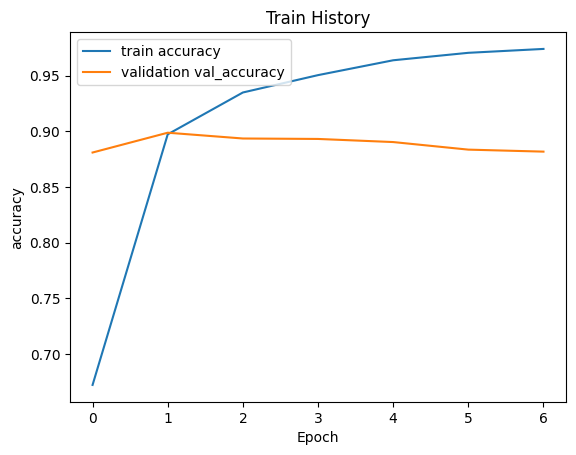

In [7]:
show_train_history(history,'accuracy','val_accuracy')

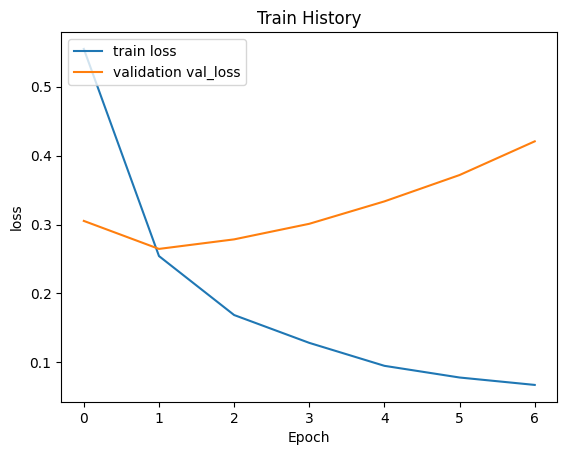

In [8]:
show_train_history(history,'loss','val_loss')

## Evaluate model by test set

In [9]:
# Test the model after training
test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')


Test results - Loss: 0.4650541841983795 - Accuracy: 85.9279990196228%


In [10]:
model.save("./models/imdb_cnn_model.h5")